In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

On fixe comme fin "2021-01-12" pour continuer de trader sur la dernière année (si on a pas assez d'instant le rebalancement ne se fait plus) (2345 instants jusqu'à fin avril 2020)

In [2]:
tickers = ['VTI', 'AGG', 'DBC', '^VIX']
data = yf.download(tickers, start="2011-01-01", end="2021-01-12", interval="1d")['Adj Close']
data_na = data.dropna(axis=0).copy() 

for column in data_na.columns:
    data_na.loc[:, f'{column}_r(t)'] = data_na[column].pct_change()
    data_na.loc[:, f'{column}_r(t+1)'] = data_na[f'{column}_r(t)'].shift(-1)

data_na.dropna(axis=0, inplace=True)
data_na.reset_index(inplace=True)
data_na['Date'] = data_na['Date'].dt.date

[*********************100%***********************]  4 of 4 completed


In [3]:
data_na

Ticker,Date,AGG,DBC,VTI,^VIX,AGG_r(t),AGG_r(t+1),DBC_r(t),DBC_r(t+1),VTI_r(t),VTI_r(t+1),^VIX_r(t),^VIX_r(t+1)
0,2011-01-04,73.619270,25.130905,51.113720,17.379999,0.000284,-0.004827,-0.013372,0.010623,-0.001981,0.005499,-0.013061,-0.020713
1,2011-01-05,73.263947,25.397863,51.394779,17.020000,-0.004827,0.000191,0.010623,-0.013411,0.005499,-0.002279,-0.020713,0.022327
2,2011-01-06,73.277916,25.057262,51.277664,17.400000,0.000191,0.003232,-0.013411,-0.003674,-0.002279,-0.002284,0.022327,-0.014943
3,2011-01-07,73.514786,24.965210,51.160561,17.139999,0.003232,0.002654,-0.003674,0.011799,-0.002284,0.000763,-0.014943,0.023337
4,2011-01-10,73.709862,25.259783,51.199596,17.540001,0.002654,-0.001984,0.011799,0.011297,0.000763,0.003964,0.023337,-0.037058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2021-01-04,106.485451,13.851583,181.573761,26.969999,-0.001269,-0.001017,-0.005442,0.028044,-0.014231,0.008078,0.185494,-0.060437
2517,2021-01-05,106.377167,14.240035,183.040573,25.340000,-0.001017,-0.004918,0.028044,0.001331,0.008078,0.008996,-0.060437,-0.010655
2518,2021-01-06,105.853958,14.258984,184.687210,25.070000,-0.004918,-0.001023,0.001331,0.004651,0.008996,0.016038,-0.010655,-0.107698
2519,2021-01-07,105.745720,14.325304,187.649261,22.370001,-0.001023,-0.001194,0.004651,0.007937,0.016038,0.004841,-0.107698,-0.036209


In [4]:
spot = data_na[['AGG', 'DBC', 'VTI', '^VIX']].to_numpy()

In [44]:
spot = data_na[['AGG', 'DBC', 'VTI', '^VIX']].to_numpy()
# Time grid
years  = 10
N  = len(spot)
d=4
t  = np.linspace(start=0, stop=years, num=N)

log_returns = np.log(spot[1:] / spot[:-1])  # Rendements logarithmiques
sigma = log_returns.std(axis=0) * np.sqrt(252)  


# Rebalancements
index_rebalancing = np.arange(0, N, 21*12)    # rebalancement annuel
C = 0.0001  # 1 bps

In [7]:
index_rebalancing

array([   0,  252,  504,  756, 1008, 1260, 1512, 1764, 2016, 2268, 2520])

In [8]:
# Calculs du portefeuille
allocation1 = [0.25, 0.25, 0.25, 0.25]
allocation2 = [0.5, 0.1, 0.2, 0.2]
allocation3 = [0.1, 0.5, 0.2, 0.2]
allocation4 = [0.4, 0.4, 0.1, 0.1]

portfolio_value   = np.ones(shape=N)
weights_actual    = np.zeros(shape=(N, d))
weights_target = np.tile(allocation1, (len(index_rebalancing), 1))
rebalancing_cost  = np.zeros(shape=len(index_rebalancing))

In [9]:
for s, (start, stop) in enumerate(zip(index_rebalancing[:-1], index_rebalancing[1:])):
    period = slice(start, stop+1)

    rebalancing_cost[s]     = portfolio_value[start] * np.abs(weights_target[s] - weights_actual[start]).sum() * C

    weights_actual[period]  = (spot[period] / spot[start]) * weights_target[s]
    weights_actual[period] /= weights_actual[period].sum(axis=1, keepdims=True)

    portfolio_returns       = (spot[period] / spot[start] - 1) @ weights_target[s]
    portfolio_value[period] = (portfolio_value[start] - rebalancing_cost[s]) * (1 + portfolio_returns)

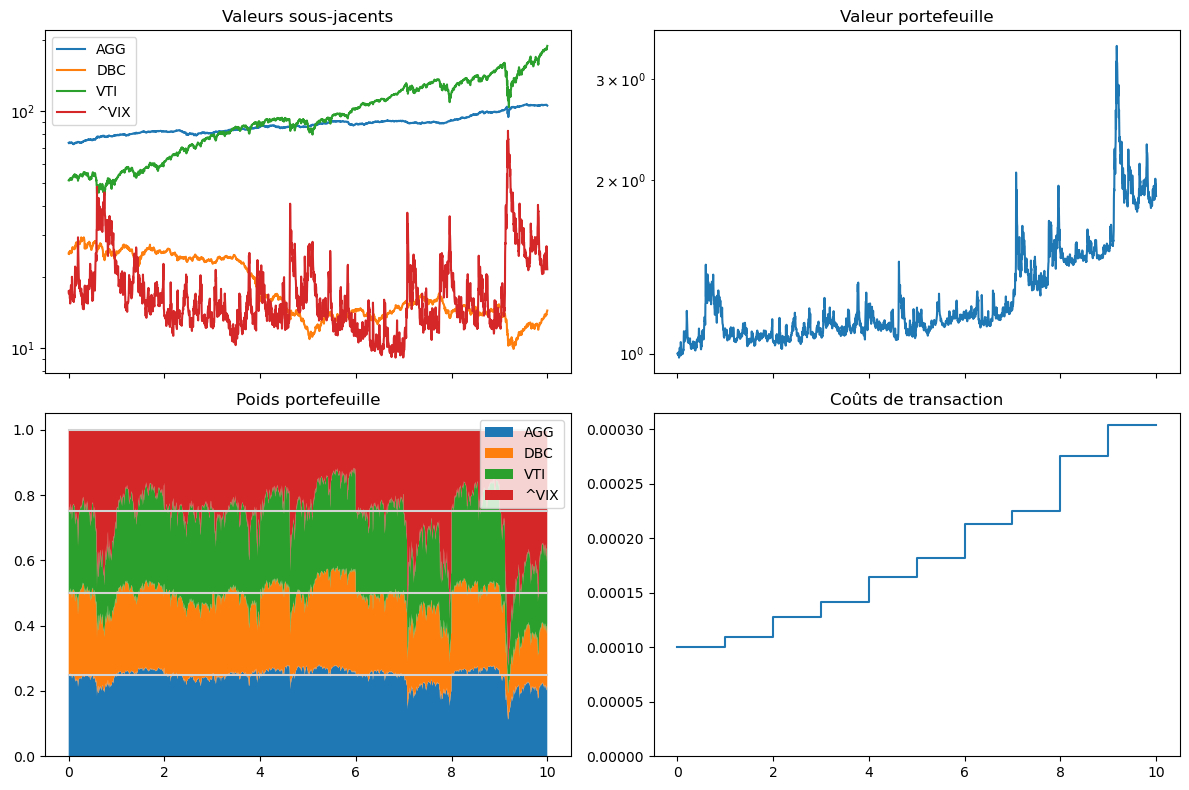

In [10]:
# Plots
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))

ax = axes[0, 0]
ax.set_title("Valeurs sous-jacents")
ax.plot(t, spot)
ax.set_yscale("log")
ax.legend(['AGG', 'DBC', 'VTI', '^VIX'])
ylim = ax.get_ylim()


ax = axes[0, 1]
ax.set_title("Valeur portefeuille")
ax.plot(t, portfolio_value)
ax.set_yscale("log")

ax = axes[1, 0]
ax.set_title("Poids portefeuille")
ax.stackplot(t, *weights_actual.T)
weights_theory  = weights_target
weights_theory /= weights_theory.sum(axis=1, keepdims=True)
ax.plot(t[index_rebalancing], weights_theory.cumsum(axis=1), color="lightgrey")
ax.legend(['AGG', 'DBC', 'VTI', '^VIX'])


ax = axes[1, 1]
ax.set_title("Coûts de transaction")
ax.step(t[index_rebalancing], rebalancing_cost.cumsum(), where="post")
ax.set_ylim((0, None))

fig.tight_layout()
plt.show()

In [11]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_value.mean()
expected_return = expected_return-1
# Calcul de la standard déviation
std_dev = portfolio_value.std()
std_dev = std_dev 
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.2748
Standard déviation : 0.2956
Sharpe ratio : 0.9294


## Prise en compte de la volatilité scaling (eq 7)

In [27]:
def compute_rolling_volatility(value, window):
    returns = np.diff(np.log(value), n=1, axis=0)
    volatility = np.lib.stride_tricks.sliding_window_view(
        returns, window_shape=window, axis=0
    ).std(axis=-1)
    return volatility * np.sqrt(252)


# Parameters
target_volatility = 0.1
w = 50  # window of 50 days


In [35]:
volatility = compute_ewm_volatility(value=spot, window=w)
portfolio_volatility = compute_ewm_volatility(value=portfolio_value, window=w)
portfolio_volatility_controlled = compute_ewm_volatility(value=portfolio_value_controlled, window=w)

In [13]:
# Contrôle de celle-ci
portfolio_value_controlled   = np.ones(shape=N)
rebalancing_cost_controlled  = np.zeros(shape=N)
weights_target_controlled    = np.ones(shape=(N, d)) / d
weights_actual_controlled    = np.zeros(shape=(N, d+1))

In [43]:
for s in range(N-1):
    if s < w:
        realized_volatility = target_volatility
    else:
        realized_volatility = compute_rolling_volatility(value=spot[s-w: s+1], window=w)
    rescaling_volatility = target_volatility / realized_volatility

    weights_target_controlled[s]    = weights_target_controlled[s] * rescaling_volatility
    weights_target_controlled[s]   /= np.maximum(1, weights_target_controlled[s].sum())

    rebalancing_cost_controlled[s]  = portfolio_value_controlled[s] * np.abs(weights_target_controlled[s] - weights_actual_controlled[s, :-1]).sum() * C

    weights_actual_controlled[s+1, :-1]  = (spot[s+1] / spot[s]) * weights_target_controlled[s]
    weights_actual_controlled[s+1, :-1] /= np.maximum(1, weights_actual_controlled[s+1].sum())
    weights_actual_controlled[s+1, -1]   = 1 - weights_actual_controlled[s+1, :-1].sum()    # cash

    portfolio_returns_controlled    = (spot[s+1] / spot[s] - 1) @ weights_target_controlled[s]
    portfolio_value_controlled[s+1] = (portfolio_value_controlled[s] - rebalancing_cost_controlled[s]) * (1 + portfolio_returns_controlled)

volatility = compute_rolling_volatility(value=spot, window=w)
portfolio_volatility = compute_rolling_volatility(value=portfolio_value, window=w)
portfolio_volatility_controlled = compute_rolling_volatility(value=portfolio_value_controlled, window=w)

InvalidIndexError: (slice(None, None, None), 0)

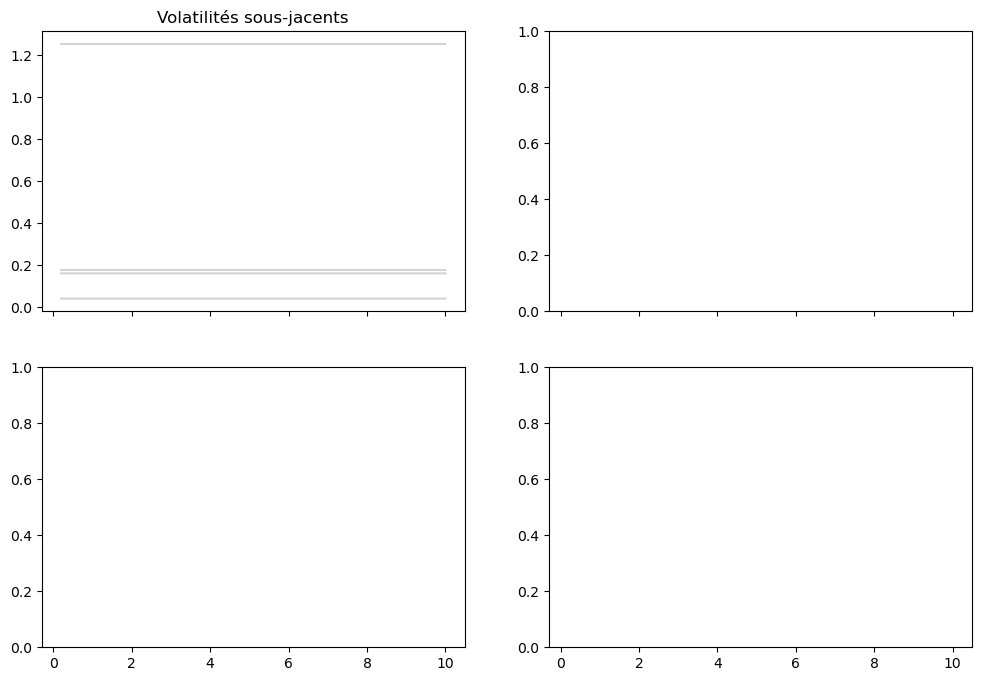

In [41]:
# Plots
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))

ax = axes[0, 0]
ax.set_title("Volatilités sous-jacents")
ax.plot(t[w:], np.tile(sigma, reps=(N-w, 1)), color="lightgrey")
for i, label in enumerate(['AGG', 'DBC', 'VTI', '^VIX']):
    ax.plot(t[w:], volatility[:, i], label=label)

ax.legend()

ax = axes[0, 1]
ax.set_title("Valeurs portefeuilles")
ax.plot(t, portfolio_value, label="Portfolio Value")
ax.plot(t, portfolio_value_controlled, label="Controlled Portfolio Value")
ax.set_yscale("log")
ax.legend()


ax = axes[1, 0]
ax.set_title("Poids portefeuille")
labels = ['AGG', 'DBC', 'VTI', '^VIX', 'cash']
ax.stackplot(t, *weights_actual_controlled.T, labels=labels)
ax.plot(t[index_rebalancing], weights_theory.cumsum(axis=1), color="lightgrey")
ax.legend()

ax = axes[1, 1]
ax.set_title("Volatilités portefeuille (mobile 50 jours)")
ax.plot(t[w:], portfolio_volatility, label="Portfolio volatility")
ax.plot(t[w:], portfolio_volatility_controlled, label="Controlled Portfolio Volatility")
ax.axhline(y=target_volatility, color="lightgrey")
ax.legend()

fig.tight_layout()
plt.show()

In [42]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_value_controlled.mean()
expected_return = expected_return-1

# Calcul de la standard déviation
std_dev = portfolio_value_controlled.std()
std_dev = std_dev 
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.3671
Standard déviation : 0.1123
Sharpe ratio : 3.2703


#######

In [298]:
# Allocation initiale
initial_allocation = [0.25, 0.25, 0.25, 0.25]  # Allocations initiales pour VTI, AGG, DBC, VIX
portfolio_value = 1
test = data_na[["Date", "AGG", "DBC", "VTI", "^VIX"]]

In [299]:
# Créer un DataFrame pour les allocations initiales
allocation_df = pd.DataFrame(index=data_na.index, columns=[f'{col}_alloc' for col in test.columns[1:]])

# Initialiser les allocations du portefeuille pour chaque actif
initial_prices = data_na.iloc[0, 1:]  # Prix initiaux des actifs
allocation_df.iloc[0] = [portfolio_value * alloc / price for alloc, price in zip(initial_allocation, initial_prices)]


In [300]:
# DataFrame pour stocker les valeurs du portefeuille
portfolio_df = pd.DataFrame(index=data_na.index, columns=['Date', 'portfolio_value'])
portfolio_df['Date'] = data_na['Date']

In [301]:
# Paramètre de période de réallocation : 'day', 'month', ou 'year'
rebalancing_period = 'day'  # Change à 'day', 'month', ou 'year' selon la fréquence souhaitée


In [ ]:
# Parcourir chaque date et réallouer le portefeuille selon la période définie
for i in range(1, len(test)):
    current_date = pd.to_datetime(test.loc[i, 'Date'])
    previous_date = pd.to_datetime(test.loc[i - 1, 'Date'])
    
    # Vérifier le changement de période pour la réallocation
    if (rebalancing_period == 'year' and current_date.year != previous_date.year) or \
       (rebalancing_period == 'month' and (current_date.year != previous_date.year or current_date.month != previous_date.month)) or \
       (rebalancing_period == 'day' and current_date != previous_date):
        
        previous_alloc = allocation_df.iloc[i - 1].values.astype(float)
        current_prices = test.iloc[i, 1:].values.astype(float)
        
        # Réallocation basée sur les prix actuels et les allocations initiales
        allocation_df.iloc[i] = rebalance_portfolio(test.iloc[i], previous_alloc, current_prices, initial_allocation)
        
        # Mettre à jour les poids basés sur la nouvelle allocation
        weights_df.loc[i] = allocation_df.iloc[i] / allocation_df.iloc[i].sum()
        
    else:
        # Conserver la même allocation et poids
        allocation_df.iloc[i] = allocation_df.iloc[i - 1]
        weights_df.loc[i] = weights_df.loc[i - 1]
    
    # Mise à jour de la valeur du portefeuille
    portfolio_df.loc[i, 'portfolio_value'] = (allocation_df.iloc[i] * test.iloc[i, 1:].values).sum() 



In [106]:
# Déterminer la première année de la période
first_date = pd.to_datetime(test['Date'].iloc[0])
first_year = first_date.year

# Initialisation du DataFrame des poids
weights_df = pd.DataFrame(index=test.index, columns=test.columns[1:])

# Poids fixes pour la première année
weights_first_year = initial_allocation  

# Assignation des poids pour la première année et les années suivantes
for i in range(len(test)):
    current_year = pd.to_datetime(test.loc[i, 'Date']).year
    
    if current_year == first_year:
        weights_df.loc[i] = weights_first_year  
    elif current_year > first_year:
        # Si c'est la première occurrence de l'année
        if i == 0 or pd.to_datetime(test.loc[i - 1, 'Date']).year != current_year:
            # Récupérer les prix de la première ligne de l'année
            first_row_prices = test.iloc[i, 1:].values.astype(float)
            # Calculer les poids basés sur la première ligne de l'année
            weights_df.loc[i] = fixed_weights = first_row_prices / first_row_prices.sum()
        else:
            # Pour les autres jours de la même année, conserver les mêmes poids
            weights_df.loc[i] = weights_df.loc[i - 1]


In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_df.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()


In [109]:
# Calculer les rendements quotidiens
returns_df = data_na[["AGG_r(t+1)", "DBC_r(t+1)", "VTI_r(t+1)", "^VIX_r(t+1)"]]

In [110]:
# Calculer le produit terme à terme
weighted_returns = returns_df.values * weights_df.values

# Somme sur les lignes pour obtenir le rendement du portefeuille
portfolio_returns = weighted_returns.sum(axis=1)

In [ ]:
portfolio_returns

In [ ]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_returns.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_returns.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


In [ ]:
portfolio_alloc_returns = pd.DataFrame(portfolio_returns, columns=["portfolio_alloc_returns"])

# Calculate cumulative returns
portfolio_alloc_returns["cumulative_rets"] = (1 + portfolio_alloc_returns["portfolio_alloc_returns"]).cumprod() - 1


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot daily returns
axs[0].plot(portfolio_alloc_returns["portfolio_alloc_returns"].values, label="daily returns")
axs[0].legend()
axs[0].set_title("Daily Portfolio Returns")

# Plot cumulative returns
axs[1].plot(portfolio_alloc_returns["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()


## Prise en compte du cout de transaction

In [113]:
C = 0.0005 

# Initialisation du vecteur des coûts de transaction
transaction_costs = np.zeros(len(weights_df))

# Calcul des coûts de transaction
for t in range(2, len(weights_df)):
    # Calcul des différences de poids
    diff_weights = weights_df.iloc[t - 1].values - weights_df.iloc[t - 2].values
    
    # Somme des valeurs absolues des différences
    sum_abs_diff = np.sum(np.abs(diff_weights))
    
    # Coût de transaction pour le temps t
    transaction_costs[t] = C * sum_abs_diff


In [114]:
portfolio_with_transac_cost = portfolio_returns - transaction_costs

In [ ]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_with_transac_cost.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_with_transac_cost.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


## Prise en compte de la volatilité scaling

In [116]:
# Initialisation du DataFrame pour stocker les volatilités ex-ante
volatility_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

# Boucle sur chaque colonne (actif) pour calculer la volatilité
for col in returns_df.columns:
    # Calcul de la variance exponentiellement pondérée sur 50 jours
    ew_var = returns_df[col].ewm(span=50, adjust=False).var()
    
    # Calcul de la volatilité ex-ante en prenant la racine carrée de la variance
    volatility_df[col] = ew_var.shift(1).apply(lambda x: x**0.5)



In [ ]:
volatility_df.iloc[48:53]

In [118]:
# Définition du paramètre alpha
vol_target = 0.1 

vol_scale_df = vol_target / volatility_df


In [119]:
# Suppression des deux premières lignes de vol_scale_df
vol_scale_df = vol_scale_df.iloc[2:]

In [ ]:
# Création du graphique
vol_scale_df.plot(figsize=(10, 6))
plt.title("Volatility Scaling")
plt.xlabel("Date")
plt.ylabel("Volatility Scale")
plt.show()

In [121]:
returns_df = returns_df.iloc[2:]
weights_df = weights_df.iloc[2:]

In [122]:
# Calculer le produit terme à terme
weighted_returns = vol_scale_df * returns_df.values * weights_df.values 

In [123]:
# Somme sur les lignes pour obtenir le rendement du portefeuille
portfolio_returns = weighted_returns.sum(axis=1)


In [124]:
# Initialisation du vecteur des coûts de transaction
transaction_costs = np.zeros(len(weights_df))

# Calcul des coûts de transaction
for t in range(2, len(weights_df)):
    # Calcul des différences de poids
    diff_weights = vol_scale_df.iloc[t - 1].values*weights_df.iloc[t - 1].values - vol_scale_df.iloc[t - 2].values*weights_df.iloc[t - 2].values
    
    # Somme des valeurs absolues des différences
    sum_abs_diff = np.sum(np.abs(diff_weights))
    
    # Coût de transaction pour le temps t
    transaction_costs[t] = C * sum_abs_diff



In [125]:
portfolio_with_transac_cost = portfolio_returns - transaction_costs

In [ ]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_with_transac_cost.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_with_transac_cost.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")
